In [ ]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=ca3ba96ce0b57a44c6620dc4fba8dd12b1ee00ab510641f4916532227bdd1bf6
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
import yfinance as yf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def LagguerreRSI(data, gamma):
    # Create base data structures
    out = []
    l =[np.zeros(4), [data.iloc[0]]*4]
    cu =np.zeros(3)
    cd =np.zeros(3)
    for i in data.index:
        # Different calculation for if it is the first price value
        l[0][0] = ((1-gamma)*data[i]) + (gamma*l[1][0])
        l[0][1] = ((-gamma)*l[0][0]) + l[1][0] + (gamma*l[1][1])
        l[0][2] = ((-gamma)*l[0][1]) + l[1][1] + (gamma*l[1][2])
        l[0][3] = ((-gamma)*l[0][2]) + l[1][2] + (gamma*l[1][3])
        # Calculate the Count Up and Count Down   
        cu[0] = l[0][0] - l[0][1] if l[0][0] >= l[0][1] else 0
        cu[1] = cu[0] + (l[0][1] - l[0][2]) if l[0][1] >= l[0][2] else cu[0]
        cu[2] = cu[1] + (l[0][2] - l[0][3]) if l[0][2] >= l[0][3] else cu[1]
        
        cd[0] = 0 if l[0][0] >= l[0][1] else l[0][1] - l[0][0]
        cd[1] = cd[0] if l[0][1] >= l[0][2] else cd[0] + (l[0][2] -l[0][1])
        cd[2] = cd[1] if l[0][2] >= l[0][3] else cd[1] + (l[0][3] - l[0][2])
        # Calculate the RSI from the final CU and CD
        out.append(cu[2]/(cu[2] + cd[2]) if (cu[2] + cd[2]) != 0 else 0)
        # Store the Laguerre values to another list so previous values can be reffed
        l[1] = l[0]
        l[0] = np.zeros(4)
                
    return out


In [ ]:
data = pd.read_csv('/content/drive/My Drive/data/forex_symbols.csv')

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def calculate_k(df):
  close = df.Close
  highest_high = df.High.rolling(10).max()
  lowest_low = df.Low.rolling(10).min()
  df['per_k_10'] = (close - lowest_low)/(highest_high-lowest_low)
  return df

def calculate_d(df):
  df['per_d_10'] = df['per_k_10'].rolling(10).mean()
  return df

def stoichastic_osc(df):
  df_new = calculate_k(df)
  df_new = calculate_d(df_new)
  return df_new

def macd_signal(df):
  exp1 = df.Close.ewm(span=12, adjust=False).mean()
  exp2 = df.Close.ewm(span=26, adjust=False).mean()
  df['macd'] = exp1-exp2
  df['macd_signal'] = df.macd.ewm(span=9, adjust=False).mean()
  return df

In [ ]:
def MinMax(x):
    xt = (x-min(x))/(max(x)-min(x))
    return xt.fillna(0)

curDict = {}
for c in tqdm(data.Symbol.tolist()):
  ticker = yf.Ticker(c)
  tmp = ticker.history(period='10d', interval='5m')
  cols = ['Open','High', 'Low', 'Close']
  tmp = tmp[cols] 
  
  # min_c = tmp.apply(min, axis=0).to_dict()
  # max_c = tmp.apply(max, axis=0).to_dict()
  # tmp = tmp.apply(MinMax, axis=0)
  tmp['time'] = (tmp.index.hour*60 + tmp.index.minute) /1440
  tmp['sma'] = tmp.Close.rolling(20).mean()
  tmp = stoichastic_osc(tmp)
  tmp = macd_signal(tmp)
  std = tmp.Close.rolling(20).std()
  tmp['upper_bol'] = tmp['sma'] + (2*std)
  tmp['lower_bol'] = tmp['sma'] - (2*std)
  # tmp['z_bol'] = (tmp.Close - tmp['sma'])/(std*2)
  tmp['RSI_point8'] = tmp[['Close']].apply(LagguerreRSI, gamma = 0.8)
  price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
  # for col in price_cols:
  #   tmp[col] = (tmp[col]-tmp[price_cols].values.min())/(tmp[price_cols].values.max()-tmp[price_cols].values.min())
  curDict[c] =  tmp.dropna()

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


In [ ]:
price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
macd_cols = ['macd','macd_signal']
osc_cols = ['per_k_10', 'per_d_10']
non_scaled_cols = ['time','RSI_point8']


In [ ]:
df = curDict[c]

In [ ]:
all_cols = df.columns

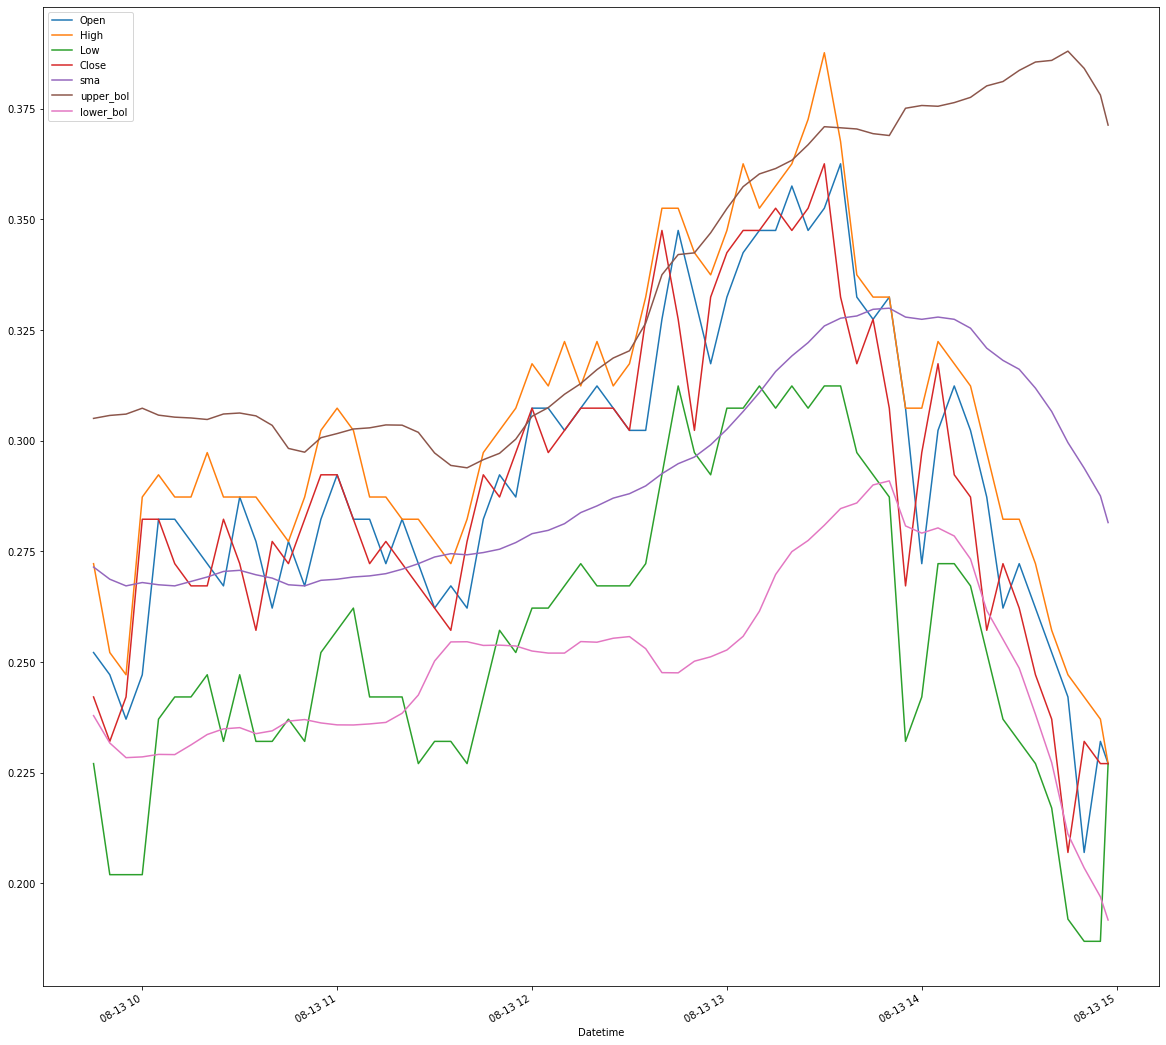

In [ ]:
((df[price_cols]-df[price_cols].values.min())/(df[price_cols].values.max()-df[price_cols].values.min()))[-64:].plot(figsize= (20,20))

In [ ]:
price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
macd_cols = ['macd','macd_signal']
osc_cols = ['per_k_10', 'per_d_10']
non_scaled_cols = ['time','RSI_point8']
seq_length = 128
def MinMax(x):
    xt = (x-min(x))/(max(x)-min(x))
    return xt.fillna(0)

def ztransform(x):
    return (x-np.mean(x))/np.std(x)
x = []
y = []
for c in tqdm(data.Symbol.tolist()):
    df = curDict[c]
    # df['time'] = (df.index.hour*60 + df.index.minute) /1440
    for i in range(len(df)-(seq_length*2)):
    # for i in range(int(len(df) / seq_length)):
        # start_idx = i*seq_length
        obs = df.iloc[i:i+seq_length*2]
        if obs.values.shape[0] == seq_length*2:
          price_obs = obs[price_cols].values
          price_obs = (price_obs - price_obs.min())/(price_obs.max()-price_obs.min())
          macd_obs = obs[macd_cols].values
          macd_obs = (macd_obs - macd_obs.min())/(macd_obs.max()-macd_obs.min())
          osc_obs = obs[osc_cols].values
          osc_obs = (osc_obs - osc_obs.min())/(osc_obs.max()-osc_obs.min())
          other_obs = obs[non_scaled_cols].values
          obs = np.concatenate([price_obs, macd_obs,osc_obs,other_obs], axis=1)
          # print(obs.shape)
          
          y.append(obs[seq_length:,:])
          x.append(obs[:seq_length,:])
              # if fore.High.max()>obs.High.max(): 
              #     y.append([0,0,1])
              # elif fore.Low.min()<obs.Low.min(): 
              #     y.append([1,0,0])
              # else:
              #     y.append([0,1,0])
        

            

100%|██████████| 28/28 [04:24<00:00,  9.45s/it]


In [ ]:
import pickle

with open('/content/drive/My Drive/data/training_set.pkl', 'wb') as f:
  pickle.dump({'x':np.array(x),'y':np.array(y)},f)

with open('/content/drive/My Drive/data/training_set_raw.pkl', 'wb') as f:
  pickle.dump(curDict,f)

In [ ]:
import pickle

with open('/content/drive/My Drive/data/training_set.pkl', 'rb') as f:
  trainDict = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(trainDict['x'])
Y = np.array(trainDict['y'])
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(X.shape[0], X.shape[1], X.shape[2],1), Y, test_size=0.2)


In [ ]:
from IPython import display

import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow.keras.backend as K

def relu_tanh(x):
    x = K.tanh(x)
    x = K.clip(x, min_value=0.0, max_value=None)
    return x

In [ ]:
# Define our metrics
test_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
test_rec = tf.keras.metrics.Mean('val_rec_loss', dtype=tf.float32)
test_nnl = tf.keras.metrics.Mean('val_nnl_loss', dtype=tf.float32)
train_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
train_rec = tf.keras.metrics.Mean('rec_loss', dtype=tf.float32)
train_nnl = tf.keras.metrics.Mean('nnl_loss', dtype=tf.float32)



In [ ]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(128, 13,1)),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
#                 tf.keras.layers.MaxPooling2D(pool_size=2),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                       strides = 1, padding='same',activation='relu'),
                tf.keras.layers.Dropout(0.5),
#                 tf.keras.layers.MaxPooling2D(pool_size=2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(500, activation='relu'),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dense(units=128*13*128, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(128,13, 128)),
#                 tf.keras.layers.UpSampling1D(size=2),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=3, strides=1,padding='same',
                    activation='relu'),
#                 tf.keras.layers.UpSampling1D(size=2),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=3, strides=1,padding='same', activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1,padding='same')

            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
SGD_clip = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.0)

def log_normal_pdf(sample, mean, logvar, beta,raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * (beta * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)), 
      axis=raxis)


def compute_loss(model, x, beta):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2,3])
    logpz = log_normal_pdf(z, 0., 0., beta)
    logqz_x = log_normal_pdf(z, mean, logvar, beta)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x), logpx_z, logqz_x


@tf.function
def train_step(model, x, optimizer, beta):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss, nnl, rec = compute_loss(model, x, beta)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_rec(rec)
    train_nnl(nnl)

In [ ]:
epochs = 50
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 6
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 13, 128)      1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 13, 128)      512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 13, 128)      147584    
_________________________________________________________________
dropout (Dropout)            (None, 128, 13, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 212992)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               106496500 
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
train_size = X_train.shape[0]
batch_size = 64
test_size = X_test.shape[0]

train_dataset = (tf.data.Dataset.from_tensor_slices(X_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test)
                .shuffle(test_size).batch(batch_size))

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions, z
    

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :]

In [ ]:

import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
beta = 1

optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9,beta_2=0.999,epsilon=None, decay=0.0, amsgrad=False)

for epoch in tqdm(range(1, epochs + 1)):
  start_time = time.time()
  loss = tf.keras.metrics.Mean()
  rec_loss = tf.keras.metrics.Mean()
  nnl_loss = tf.keras.metrics.Mean()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer, beta)
    ls, nnl, rec = compute_loss(model, train_x, beta)
    loss(ls)
    rec_loss(rec)
    nnl_loss(nnl)
  elbo = -loss.result()

  with train_summary_writer.as_default():
      tf.summary.scalar('loss', elbo, step=epoch)
      tf.summary.scalar('rec_loss', rec_loss.result(), step=epoch)
      tf.summary.scalar('nnl_loss', nnl_loss.result(), step=epoch)
  end_time = time.time()

  test_loss = tf.keras.metrics.Mean()
  test_rec_loss = tf.keras.metrics.Mean()
  test_nnl_loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
      ls, nnl, rec = compute_loss(model, test_x, beta)
      test_loss(ls)
      test_rec_loss(rec)
      test_nnl_loss(nnl)
  test_elbo = -test_loss.result()

  with test_summary_writer.as_default():
      tf.summary.scalar('loss', test_elbo, step=epoch)
      tf.summary.scalar('rec_loss', test_rec_loss.result(), step=epoch)
      tf.summary.scalar('nnl_loss', test_nnl_loss.result(), step=epoch)

  print('Epoch: {}, Train set ELBO: {},Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, test_elbo,end_time - start_time))

  loss.reset_states()
  rec_loss.reset_states()
  nnl_loss.reset_states()
  test_loss.reset_states()
  test_rec_loss.reset_states()
  test_nnl_loss.reset_states()
    

  2%|▏         | 1/50 [02:07<1:44:27, 127.91s/it]

Epoch: 1, Train set ELBO: -1024.9453125,Test set ELBO: -1002.7977905273438, time elapse for current epoch: 121.17112970352173


  4%|▍         | 2/50 [04:10<1:40:56, 126.18s/it]

Epoch: 2, Train set ELBO: -999.4860229492188,Test set ELBO: -998.3555297851562, time elapse for current epoch: 115.57122254371643


  6%|▌         | 3/50 [06:11<1:37:49, 124.88s/it]

Epoch: 3, Train set ELBO: -994.2901611328125,Test set ELBO: -993.32275390625, time elapse for current epoch: 115.29637289047241


  8%|▊         | 4/50 [08:13<1:35:05, 124.04s/it]

Epoch: 4, Train set ELBO: -989.2035522460938,Test set ELBO: -989.1134643554688, time elapse for current epoch: 115.50725078582764


 10%|█         | 5/50 [10:15<1:32:31, 123.37s/it]

Epoch: 5, Train set ELBO: -984.004638671875,Test set ELBO: -984.597900390625, time elapse for current epoch: 115.26945662498474


 12%|█▏        | 6/50 [12:17<1:30:03, 122.81s/it]

Epoch: 6, Train set ELBO: -978.8662719726562,Test set ELBO: -980.4806518554688, time elapse for current epoch: 115.00057101249695


 14%|█▍        | 7/50 [14:18<1:27:42, 122.39s/it]

Epoch: 7, Train set ELBO: -973.8819580078125,Test set ELBO: -975.9606323242188, time elapse for current epoch: 114.8832938671112


 16%|█▌        | 8/50 [16:20<1:25:27, 122.07s/it]

Epoch: 8, Train set ELBO: -969.5272216796875,Test set ELBO: -972.544921875, time elapse for current epoch: 114.79231238365173


 18%|█▊        | 9/50 [18:21<1:23:14, 121.81s/it]

Epoch: 9, Train set ELBO: -965.7691040039062,Test set ELBO: -969.0789184570312, time elapse for current epoch: 114.7094624042511


 20%|██        | 10/50 [20:21<1:20:59, 121.49s/it]

Epoch: 10, Train set ELBO: -962.805419921875,Test set ELBO: -966.5505981445312, time elapse for current epoch: 114.26940417289734


 22%|██▏       | 11/50 [22:22<1:18:48, 121.25s/it]

Epoch: 11, Train set ELBO: -960.1596069335938,Test set ELBO: -964.5396118164062, time elapse for current epoch: 114.19115447998047


 24%|██▍       | 12/50 [24:23<1:16:38, 121.02s/it]

Epoch: 12, Train set ELBO: -958.0884399414062,Test set ELBO: -963.2948608398438, time elapse for current epoch: 114.01543378829956


 26%|██▌       | 13/50 [26:23<1:14:31, 120.85s/it]

Epoch: 13, Train set ELBO: -956.3197021484375,Test set ELBO: -960.9746704101562, time elapse for current epoch: 113.98166275024414


 28%|██▊       | 14/50 [28:24<1:12:27, 120.76s/it]

Epoch: 14, Train set ELBO: -954.903076171875,Test set ELBO: -958.999755859375, time elapse for current epoch: 113.97909235954285


 30%|███       | 15/50 [30:24<1:10:22, 120.64s/it]

Epoch: 15, Train set ELBO: -953.5985717773438,Test set ELBO: -958.2362670898438, time elapse for current epoch: 113.90696883201599


 32%|███▏      | 16/50 [32:24<1:08:20, 120.59s/it]

Epoch: 16, Train set ELBO: -952.5037231445312,Test set ELBO: -958.1953735351562, time elapse for current epoch: 113.96354413032532


 34%|███▍      | 17/50 [34:25<1:06:19, 120.59s/it]

Epoch: 17, Train set ELBO: -951.6761474609375,Test set ELBO: -956.5114135742188, time elapse for current epoch: 114.124098777771


 36%|███▌      | 18/50 [36:25<1:04:14, 120.46s/it]

Epoch: 18, Train set ELBO: -950.8617553710938,Test set ELBO: -955.0189819335938, time elapse for current epoch: 113.71414184570312


 38%|███▊      | 19/50 [38:25<1:02:11, 120.38s/it]

Epoch: 19, Train set ELBO: -950.0280151367188,Test set ELBO: -955.1754760742188, time elapse for current epoch: 113.70284104347229


 40%|████      | 20/50 [40:26<1:00:13, 120.45s/it]

Epoch: 20, Train set ELBO: -949.5087890625,Test set ELBO: -954.237548828125, time elapse for current epoch: 114.11606550216675


 42%|████▏     | 21/50 [42:26<58:12, 120.42s/it]  

Epoch: 21, Train set ELBO: -948.8629760742188,Test set ELBO: -954.659912109375, time elapse for current epoch: 113.86164498329163


 44%|████▍     | 22/50 [44:27<56:09, 120.34s/it]

Epoch: 22, Train set ELBO: -948.3680419921875,Test set ELBO: -953.6835327148438, time elapse for current epoch: 113.66246008872986


 46%|████▌     | 23/50 [46:27<54:08, 120.32s/it]

Epoch: 23, Train set ELBO: -947.934326171875,Test set ELBO: -952.7722778320312, time elapse for current epoch: 113.79138541221619


 48%|████▊     | 24/50 [48:27<52:07, 120.30s/it]

Epoch: 24, Train set ELBO: -947.4811401367188,Test set ELBO: -952.5940551757812, time elapse for current epoch: 113.79442524909973


 50%|█████     | 25/50 [50:27<50:07, 120.29s/it]

Epoch: 25, Train set ELBO: -947.1110229492188,Test set ELBO: -951.932373046875, time elapse for current epoch: 113.77998876571655


 52%|█████▏    | 26/50 [52:28<48:09, 120.38s/it]

Epoch: 26, Train set ELBO: -946.7904052734375,Test set ELBO: -951.7140502929688, time elapse for current epoch: 114.07426643371582


 54%|█████▍    | 27/50 [54:28<46:08, 120.38s/it]

Epoch: 27, Train set ELBO: -946.413330078125,Test set ELBO: -951.1137084960938, time elapse for current epoch: 113.93615674972534


 56%|█████▌    | 28/50 [56:28<44:07, 120.32s/it]

Epoch: 28, Train set ELBO: -946.0637817382812,Test set ELBO: -951.0790405273438, time elapse for current epoch: 113.70255589485168


 58%|█████▊    | 29/50 [58:28<42:04, 120.22s/it]

Epoch: 29, Train set ELBO: -945.807861328125,Test set ELBO: -950.7299194335938, time elapse for current epoch: 113.50107455253601


 60%|██████    | 30/50 [1:00:29<40:04, 120.25s/it]

Epoch: 30, Train set ELBO: -945.5772705078125,Test set ELBO: -950.4295043945312, time elapse for current epoch: 113.83251285552979


 62%|██████▏   | 31/50 [1:02:29<38:06, 120.33s/it]

Epoch: 31, Train set ELBO: -945.3148803710938,Test set ELBO: -950.3914184570312, time elapse for current epoch: 114.04660320281982


KeyboardInterrupt: ignored

In [ ]:
model.encoder.save_weights('/content/drive/My Drive/data/encoder1308_1.h5')
model.decoder.save_weights('/content/drive/My Drive/data/decoder1308_1.h5')

In [ ]:

import pickle
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/data/training_set.pkl', 'rb') as f:
  trainDict = pickle.load(f)

In [ ]:
model.encoder.load_weights('/content/drive/My Drive/data/encoder1308_1.h5')
model.decoder.load_weights('/content/drive/My Drive/data/decoder1308_1.h5')

Build slope prediction

In [ ]:

i = 0
for x in tqdm(X_train): 
  x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
  if i == 0:
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    train_z = z.numpy()
  else:
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    train_z = np.concatenate([train_z, z.numpy()])
  i+=1

B = []
for y_i in Y_train:
  b,_ = np.polyfit(y_i[:10,11], y_i[:10,3], deg=1)
  B.append(b)

100%|██████████| 49016/49016 [51:04<00:00, 15.99it/s]


No handles with labels found to put in legend.


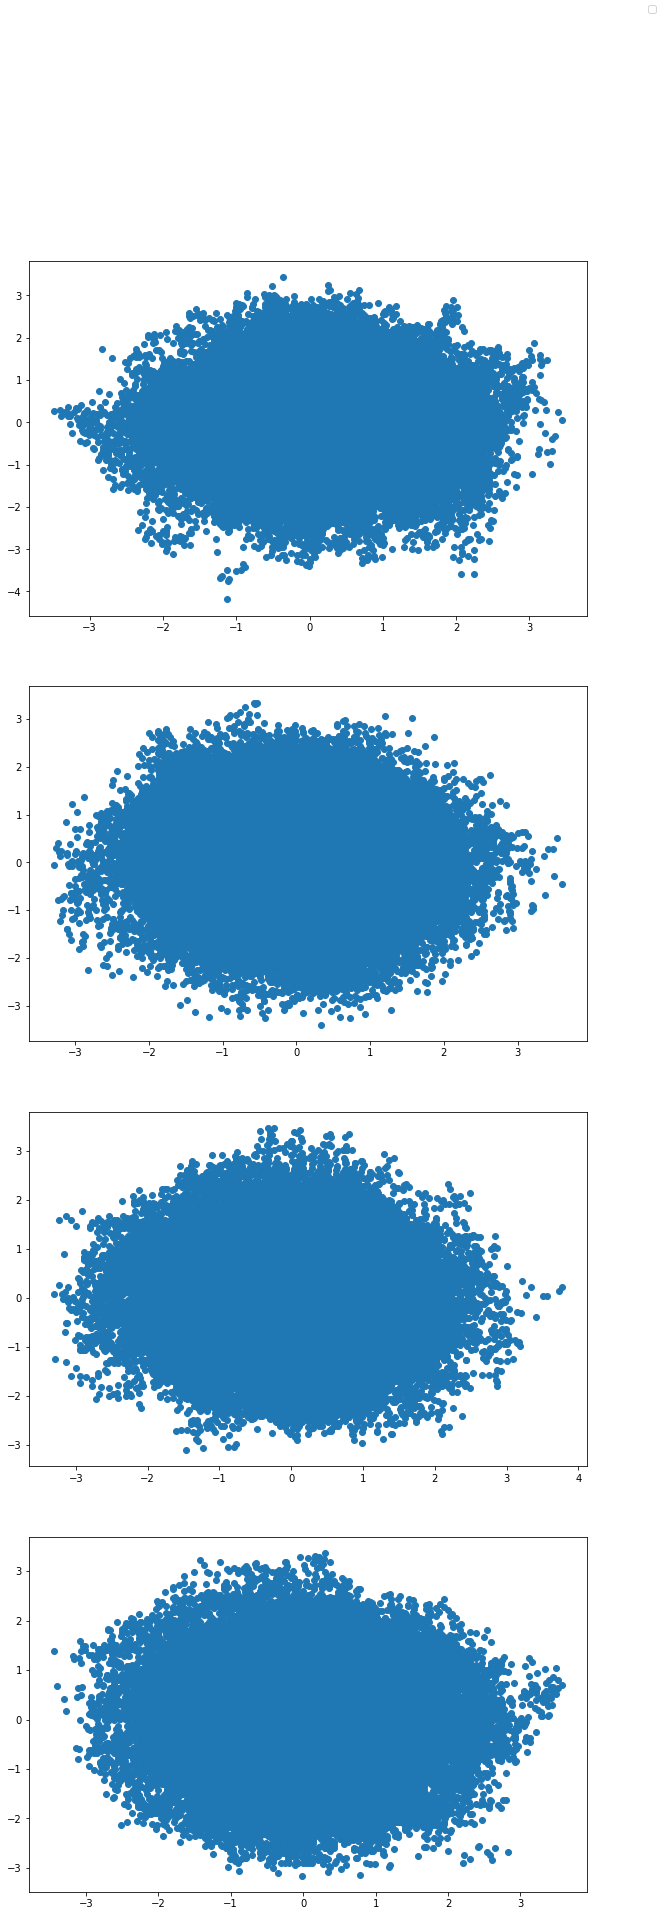

In [ ]:
from sklearn.decomposition import PCA
pca = PCA( n_components=2)
pca_comp = pca.fit_transform(train_z)
fig, axs = plt.subplots(4, figsize=(10,30))
axs[0].scatter(train_z[:, 0], train_z[:, 1])
axs[1].scatter(train_z[:, 2], train_z[:, 3])
axs[2].scatter(train_z[:, 4], train_z[:, 5])
axs[3].scatter(pca_comp[:,0], pca_comp[:,1])
fig.legend()
plt.show()


# New Section

In [ ]:
pred, z = generate_and_save_images(model, 20, X_train[:5])

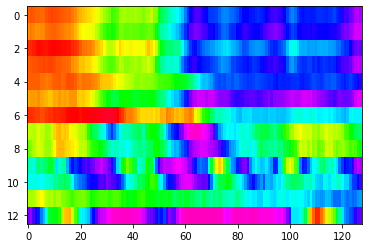

In [ ]:
plt.imshow(pred.numpy()[2].reshape((128,13)).T, aspect='auto', cmap='gist_rainbow', interpolation='nearest')

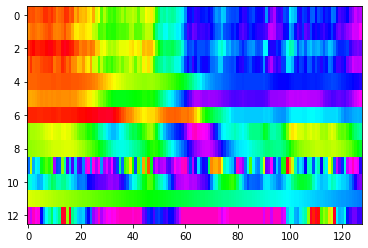

In [ ]:
plt.imshow(X_train[2].reshape((128,13)).T, aspect='auto', cmap='gist_rainbow', interpolation='nearest')

In [ ]:
price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
macd_cols = ['macd','macd_signal']
osc_cols = ['per_k_10', 'per_d_10']
non_scaled_cols = ['time','RSI_point8']

all_cols = [price_cols + macd_cols + osc_cols + non_scaled_cols]

In [ ]:
i = 0
for x in tqdm(X_test):
  x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
  if i == 0:
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    test_z = z.numpy()
  else:
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    test_z = np.concatenate([test_z, z.numpy()])
  i+=1

B_test = []
for y_i in Y_test:
  b,_ = np.polyfit(y_i[:10,11], y_i[:10,3], deg=1)
  B_test.append(b)

100%|██████████| 12255/12255 [13:27<00:00, 15.18it/s]


In [ ]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-0jbsd2_x
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-0jbsd2_x
     |████████████████████████████████| 348kB 2.7MB/s 
  Created wheel for ngboost: filename=ngboost-0.2.4.dev0-cp36-none-any.whl size=38414 sha256=fd3d6360461a6da177aab507c9cd2ee1118ebccfcc2d54de008310da8071809d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ye4qkk5d/wheels/6d/38/b0/7dc3b6546bf28b1cc407b44f75cbecf072fc2bae32e8f6a835
Successfully built ngboost


In [ ]:
from ngboost import NGBRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


ngb = NGBRegressor().fit(train_z, np.array(B))
Y_preds = ngb.predict(test_z)
Y_dists = ngb.pred_dist(test_z)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, np.array(B_test))
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(np.array(B_test)).mean()
print('Test NLL', test_NLL)

[iter 0] loss=2.7074 val_loss=0.0000 scale=1.0000 norm=2.6943
[iter 100] loss=2.6314 val_loss=0.0000 scale=2.0000 norm=5.2645
[iter 200] loss=2.6068 val_loss=0.0000 scale=1.0000 norm=2.6179
[iter 300] loss=2.5937 val_loss=0.0000 scale=1.0000 norm=2.6111
[iter 400] loss=2.5849 val_loss=0.0000 scale=1.0000 norm=2.6057
Test MSE 11.988855473795272
Test NLL 2.590488385382359


In [ ]:
pickle.dump(ngb, open('/content/drive/My Drive/data/ngboost.pkl', 'wb'))

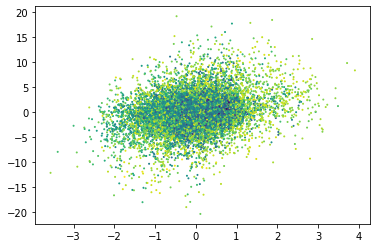

In [ ]:
plt.scatter(Y_preds,np.array(B_test), c=Y_dists.scale, s=1)

In [ ]:

curs = data.Symbol.tolist()
def MinMax(x):
    xt = (x-min(x))/(max(x)-min(x))
    return xt.fillna(0)

def ztransform(x):
    return (x-np.mean(x))/np.std(x)
predDict = {}

for c in tqdm(curs):
    df = curDict[c]
    preds = []
    idxs = []
    probs = []
    dts = []
    for i in range(len(df)-(128+15)):
        obs = df.iloc[i:i+128+15]
        if len(obs.drop_duplicates())>1:
          x = obs[:-15].apply(MinMax, axis=0).values.astype(np.float32).reshape(1,128,4,1)
          mean, logvar = model.encode(x)
          z = model.reparameterize(mean, logvar)
          test_z = z.numpy()
          preds.append(xgmodel.predict(test_z)[0])
          idxs.append([i,i+128,i+128+15])
          probs.append(xgmodel.predict_proba(test_z)[0])
          dts.append(obs.index[-15])

    predDict[c] = {'prob': probs,'pred':preds, 'idx':idxs, 'times':dts}

          

100%|██████████| 28/28 [05:03<00:00, 10.85s/it]


In [ ]:
predDict.keys()

dict_keys(['GBPUSD=X', 'GBPEUR=X', 'EURUSD=X', 'GBPJPY=X', 'JPY=X', 'GBP=X', 'GBPAUD=X', 'GBPBRL=X', 'GBPCAD=X', 'GBPCHF=X', 'GBPCNY=X', 'GBPINR=X', 'GBPNOK=X', 'GBPQAR=X', 'GBPZAR=X', 'EURCHF=X', 'EURCAD=X', 'EURJPY=X', 'EURSEK=X', 'EURHUF=X', 'CAD=X', 'USDHKD=X', 'USDSGD=X', 'INR=X', 'USDMXN=X', 'CNY=X', 'CHF=X'])

In [ ]:
tick = 'GBPAUD=X'

In [ ]:
gbpyn = pd.DataFrame(predDict[tick])

In [ ]:
gbpyn.index = pd.DatetimeIndex(gbpyn['times'])

In [ ]:
gbpyn_df = curDict[tick]

In [ ]:
results = gbpyn_df.join(gbpyn)

In [ ]:
results.columns

Index(['Open', 'High', 'Low', 'Close', 'prob', 'pred', 'idx', 'times'], dtype='object')

In [ ]:
results['up_prob'] = results['prob'].apply(lambda x: x[2] if np.isnan(x).any() != True else np.nan)
results['down_prob'] = results['prob'].apply(lambda x: x[0] if np.isnan(x).any() != True else np.nan)
results['flat_prob'] = results['prob'].apply(lambda x: x[1] if np.isnan(x).any() != True else np.nan)

In [ ]:
results.head(300)

,Open,High,Low,Close,prob,pred,idx,times,up_prob,down_prob,flat_prob
Datetime,,,,,,,,,,,
2020-08-03 00:00:00+01:00,1.8323,1.8326,1.8316,1.8324,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2020-08-03 00:01:00+01:00,1.8324,1.8328,1.8316,1.8326,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2020-08-03 00:02:00+01:00,1.8327,1.8330,1.8316,1.8324,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2020-08-03 00:03:00+01:00,1.8324,1.8328,1.8316,1.8327,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2020-08-03 00:04:00+01:00,1.8327,1.8329,1.8316,1.8327,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-03 04:57:00+01:00,1.8351,1.8354,1.8348,1.8353,"[0.12874274, 0.63893944, 0.23231779]",1.0,"[167, 295, 310]",2020-08-03 04:57:00+01:00,0.232318,0.128743,0.638939
2020-08-03 04:58:00+01:00,1.8353,1.8354,1.8349,1.8354,"[0.38554907, 0.3780363, 0.23641461]",0.0,"[168, 296, 311]",2020-08-03 04:58:00+01:00,0.236415,0.385549,0.378036
2020-08-03 04:59:00+01:00,1.8353,1.8354,1.8347,1.8348,"[0.2803058, 0.57391745, 0.1457767]",1.0,"[169, 297, 312]",2020-08-03 04:59:00+01:00,0.145777,0.280306,0.573917


In [ ]:
import plotly.graph_objects as go
threshold = 0.6
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=results.index,
    y=results['down_prob'],
    name="probability down",
    mode='lines',
    yaxis="y2"
))

fig.add_trace(go.Scatter(
    x=results.index,
    y=results['up_prob'],
    name="probability up",
    mode='lines',
    yaxis="y2"
))
# Add traces
fig.add_trace(go.Candlestick(x=results.index,
                open=results['Open'],
                high=results['High'],
                low=results['Low'],
                close=results['Close']))
fig.add_trace(go.Scatter(x=results[(results['pred']==0) & (results['down_prob']>=threshold)].index,
                         y=results[(results['pred']==0) & (results['down_prob']>=threshold)]['Close'],
                    mode='markers',
                    name='Down',
                    marker=dict(
                        size=results[results['pred']==0]['down_prob']*20
                    ),
                        marker_symbol='triangle-down'))
fig.add_trace(go.Scatter(x=results[(results['pred']==2) & (results['up_prob']>=threshold)].index,
                         y=results[(results['pred']==2) & (results['up_prob']>=threshold)]['Close'],
                    mode='markers',
                    name='Up',
                    marker=dict(
                        size=results[results['pred']==2]['up_prob']*20
                    ),
                        marker_symbol='triangle-up'))



fig.update_layout( yaxis=dict(
        title="Price",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        ),
        anchor="free"
    ),
    yaxis2=dict(
        title="probability",
        titlefont=dict(
            color="#9467bd"
        ),
        tickfont=dict(
            color="#9467bd"
        ),
        overlaying="y",
        side="right",
        anchor="free"
        
    ))

fig.show()